In [ ]:
# !conda install python-snappy

In [8]:
%matplotlib inline
# %matplotlib qt # interactive

import json

import requests
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import folium
import geopandas as gpd
from shapely.geometry import box, Polygon
from pyproj import CRS
from tqdm.notebook import tqdm
from tqdm import trange

In [2]:
# remove folium warning
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)

In [3]:
dates = requests.get('https://openaltimetry.org/data/icesat2/getTrackDate').json()
tracks = gpd.read_file(r"../data/icesat-2/icesat2_tracks.shp")

# NL
# extents = [5.35,53.4,6.2,53.5] 
# zoom = 10

# DK
extents = [8.27, 55.03, 8.75, 55.49]
zoom = 8

polygon_geom = Polygon(zip([extents[0],extents[2],extents[2],extents[0]], [extents[1],extents[1],extents[3],extents[3]]))
polygon = gpd.GeoDataFrame(index=[0], crs=CRS('EPSG:3857'), geometry=[polygon_geom])       

# Clip data
tracks_clip = gpd.clip(tracks, polygon)
track_ids = tracks_clip.TrackId.values

In [4]:
center = [polygon_geom.centroid.xy[1][0], polygon_geom.centroid.xy[0][0]]

In [5]:
m = folium.Map(center, zoom_start=zoom)
folium.GeoJson(polygon_geom).add_to(m)
folium.GeoJson(tracks_clip).add_to(m)
folium.LatLngPopup().add_to(m)
m


In [6]:
track_ids

array(['69', '511', '671', '1113'], dtype=object)

In [7]:
# track_id, track_date
overpasses = []
for track_id in track_ids:
    for track_date in dates['track_{}'.format(track_id)].split(','):
        overpasses.append([track_id, track_date])

In [8]:
rows = []

# download data for all track_id, track_date combinations
with tqdm(overpasses, ncols='100%') as t:
    log = lambda s: t.set_description(s); t.refresh()
    
    for track_id, track_date in t:
        log(f'Downloading data for track: {track_id}, date: {track_date}')

        # Paste the OpenAltimetry API URL for Photon here: 
        OA_API_URL = 'https://openaltimetry.org/data/api/icesat2/atl03?' \
            '&minx={}&miny={}&maxx={}&maxy={}&date={}&trackId={}' \
            '&beamName=gt3r&beamName=gt3l&beamName=gt2r&beamName=gt2l&beamName=gt1r&beamName=gt1l' \
            .format(extents[0], extents[1], extents[2], extents[3], track_date, track_id)

        # This function will request the 6 beams data using OpenAltimetry's API
        r = requests.get(OA_API_URL + '&client=jupyter')
        photon_data = r.json()

        # iterate over 6 beams
        for beam in photon_data:
            # every beam has data series with different confidences:
            #
            # {'beam_name': 'gt3r',
            #  'total_photon_count': 43383,
            #  'select_photon_count': 43383,
            #  'percentage': 100.0,
            #  'series': [{'name': 'Noise',
            #    'photon_count': 580,
            #    'data': [[55.48735236638138, 8.49802945875813, 37.546936],
            #     [55.48734604692815, 8.498028327844818, 42.50964],            
            beam_name = beam['beam_name']
            for s in beam['series']:
                # every series has name (confidence)
                series_name = s['name']
                
                for o in s['data']:
                    # add rows
                    row = {
                        'track_id': track_id,
                        'date': track_date,
                        'beam': beam_name,
                        'series': series_name,
                        'x': round(o[0], 6),
                        'y': round(o[1], 6),
                        'h': o[2],
                    }
            
                    rows.append(row)


In [11]:
df = pd.DataFrame(rows)

In [13]:
df

,track_id,date,beam,series,x,y,h
0,69,2019-01-01,gt3r,Noise,55.487352,8.498029,37.546936
1,69,2019-01-01,gt3r,Noise,55.487346,8.498028,42.509640
2,69,2019-01-01,gt3r,Noise,55.486350,8.497851,38.275400
3,69,2019-01-01,gt3r,Noise,55.484612,8.497551,36.516910
4,69,2019-01-01,gt3r,Noise,55.484600,8.497549,34.566850
...,...,...,...,...,...,...,...
3521142,1113,2020-03-08,gt1l,Low,55.064141,8.742853,-131.968610
3521143,1113,2020-03-08,gt1l,Low,55.064154,8.742850,-113.483025
3521144,1113,2020-03-08,gt1l,Low,55.064274,8.742829,-97.342995
3521145,1113,2020-03-08,gt1l,Low,55.082603,8.739666,-210.312240


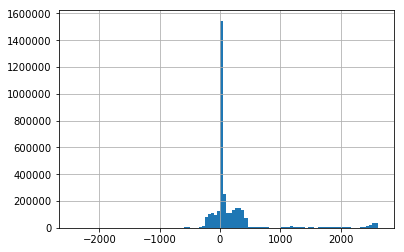

In [14]:
df.h.hist(bins=100)

In [4]:
# df.to_parquet('../data/out/icesat-2-DK.parquet')
df = pd.read_parquet('../data/out/icesat-2-DK.parquet')

In [5]:
df.columns

Index(['Unnamed: 0', 'track_id', 'date', 'beam', 'series', 'x', 'y', 'h'], dtype='object')

In [40]:
df.series.unique()

array(['Noise', 'Buffer', 'Low', 'Medium', 'High'], dtype=object)

In [41]:
df.beam.unique()

array(['gt3r', 'gt3l', 'gt2r', 'gt2l', 'gt1r', 'gt1l'], dtype=object)

In [35]:
df.track_id.unique()

array([  69,  511,  671, 1113], dtype=int64)

In [37]:
[ [track_id, df[df.track_id == track_id].date.unique()] for track_id in track_ids]

[[671,
  array(['2018-11-11', '2019-02-10', '2019-05-12', '2019-08-11',
         '2019-11-09', '2020-02-08'], dtype=object)],
 [1113,
  array(['2018-12-10', '2019-03-11', '2019-06-10', '2019-09-08',
         '2019-12-08', '2020-03-08'], dtype=object)],
 [69,
  array(['2019-01-01', '2019-04-02', '2019-10-01', '2019-12-31',
         '2020-03-31'], dtype=object)],
 [511,
  array(['2018-11-01', '2019-01-30', '2019-05-01', '2019-07-31',
         '2020-01-29'], dtype=object)]]

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

data = df[(df.track_id == 1113) & (df.date == '2019-09-08') & (df.series != 'Noise')]

ax[0].plot(data.h, '.', markersize=0.5, alpha=0.1)
ax[1].plot(data.x, data.y, '.', markersize=0.1, alpha=0.2)
plt.show()
